# Dog Heart Vertebral Heart Size Point Detection 
# 1. Build an object detection model using pytorch

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.transforms import ToTensor, Normalize, Resize, Compose
from PIL import Image
from scipy.io import loadmat

In [ ]:
import random
import numpy as np
import torch

SEED = 116
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:

class DogHeartDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms

        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.points = list(sorted(os.listdir(os.path.join(root, "Labels"))))

    def __getitem__(self, idx):

        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        points_path = os.path.join(self.root, "Labels", self.points[idx])
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        if self.transforms is not None:
            img = self.transforms(img)
        h_new, w_new = img.shape[1], img.shape[2]
        mat = loadmat(points_path)
        six_points = mat['six_points'].astype(float)
        six_points = torch.as_tensor(six_points, dtype=torch.float32)
        six_points[:,0] = w_new/w*six_points[:,0]
        six_points[:,1] = h_new/h*six_points[:,1]
        six_points = torch.reshape(six_points, (-1,))/h_new
        VHS = mat['VHS'].astype(float)
        VHS  = torch.as_tensor(VHS, dtype=torch.float32)
        return img, six_points, VHS

    def __len__(self):
        return len(self.imgs)
    

def get_transform(resized_image_size):
    transforms = []
    transforms.append(T.ToTensor())
    transforms.append(T.Resize(size = (resized_image_size,resized_image_size)))
    transforms.append(T.Normalize(mean = [0.485,0.456,0.406], std = [0.229, 0.224, 0.225]))
    return T.Compose(transforms)


batch_size = 8
resized_image_size = 512
dataset_train = DogHeartDataset('/kaggle/input/dog-heart-vhs/Dog_Heart_VHS/Train', get_transform(resized_image_size))
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
for images, keypoints, vhs in data_loader_train:
    print("Images shape:", images.shape)
    print("Keypoints shape:", keypoints.shape)
    print("VHS shape:", vhs.shape)
    break   
    
'''
## Get origial image size and return predicted points back to original points size
w, h = img.size
# Make predictions using trained model
points = model(img)*resized_image_size
points = torch.reshape(points, (-1, 2))
points[:,0] = w/resized_image_size*points[:,0]
points[:,1] = h/resized_image_size*points[:,1]
'''

Images shape: torch.Size([8, 3, 512, 512])
Keypoints shape: torch.Size([8, 12])
VHS shape: torch.Size([8, 1, 1])


'\n## Get origial image size and return predicted points back to original points size\nw, h = img.size\n# Make predictions using trained model\npoints = model(img)*resized_image_size\npoints = torch.reshape(points, (-1, 2))\npoints[:,0] = w/resized_image_size*points[:,0]\npoints[:,1] = h/resized_image_size*points[:,1]\n'

In [ ]:
val_dataset = DogHeartDataset('/kaggle/input/dog-heart-vhs/Dog_Heart_VHS/Valid', get_transform(resized_image_size))
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
for images, keypoints, vhs in val_data_loader:
    print("Images shape:", images.shape)
    print("Keypoints shape:", keypoints.shape)
    print("VHS shape:", vhs.shape)
    break

Images shape: torch.Size([8, 3, 512, 512])
Keypoints shape: torch.Size([8, 12])
VHS shape: torch.Size([8, 1, 1])


In [11]:
import torch
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
import torch.nn as nn
import timm

class HRNetKeypointRegressor(nn.Module):
    def __init__(self, num_keypoints, pretrained=True):
        super(HRNetKeypointRegressor, self).__init__()
        self.backbone = timm.create_model("hrnet_w32", pretrained=pretrained, features_only=True)
        self.num_keypoints = num_keypoints

        self.fc1 = nn.Linear(1024 * 16 * 16, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_keypoints * 2)

    def forward(self, x):
        x = self.backbone(x)[-1]
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


/Users/vaibhavchemboli/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [9]:
import torch
torch.cuda.empty_cache()

In [9]:

num_keypoints = 6
model = HRNetKeypointRegressor(num_keypoints=num_keypoints)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Unexpected keys (downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.num_batches_tracked, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.num_batches_tracked, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.num_batches_tracked, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


# 2. Train your model using [Dog VHS Dataset](https://yuad-my.sharepoint.com/:f:/g/personal/youshan_zhang_yu_edu/ErguFJBE4y9KqzEdWWNlXzMBkTbsBaNX9l856SyvQauwJg?e=L3JOuN)

Epoch [1/200], Train Loss: 0.0366, Train Accuracy: 0.3786, Val Loss: 0.0015, Val Accuracy: 0.5750, Time: 156.70 seconds
Epoch [2/200], Train Loss: 0.0011, Train Accuracy: 0.7229, Val Loss: 0.0018, Val Accuracy: 0.3967, Time: 142.62 seconds
Epoch [3/200], Train Loss: 0.0008, Train Accuracy: 0.8058, Val Loss: 0.0006, Val Accuracy: 0.8942, Time: 141.38 seconds
Epoch [4/200], Train Loss: 0.0005, Train Accuracy: 0.9146, Val Loss: 0.0005, Val Accuracy: 0.9225, Time: 141.80 seconds
Epoch [5/200], Train Loss: 0.0005, Train Accuracy: 0.9294, Val Loss: 0.0004, Val Accuracy: 0.9442, Time: 142.20 seconds
Epoch [6/200], Train Loss: 0.0004, Train Accuracy: 0.9380, Val Loss: 0.0004, Val Accuracy: 0.9450, Time: 141.86 seconds
Epoch [7/200], Train Loss: 0.0004, Train Accuracy: 0.9549, Val Loss: 0.0004, Val Accuracy: 0.9408, Time: 142.11 seconds
Epoch [8/200], Train Loss: 0.0003, Train Accuracy: 0.9656, Val Loss: 0.0005, Val Accuracy: 0.9083, Time: 142.38 seconds
Epoch [9/200], Train Loss: 0.0004, Train

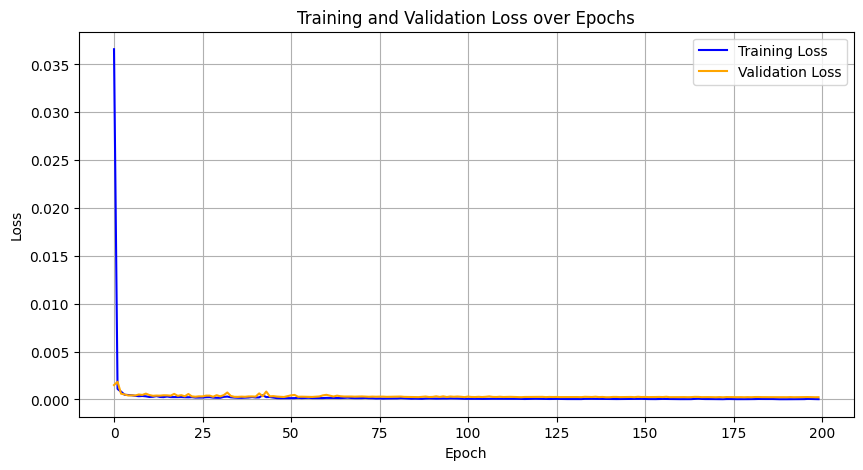

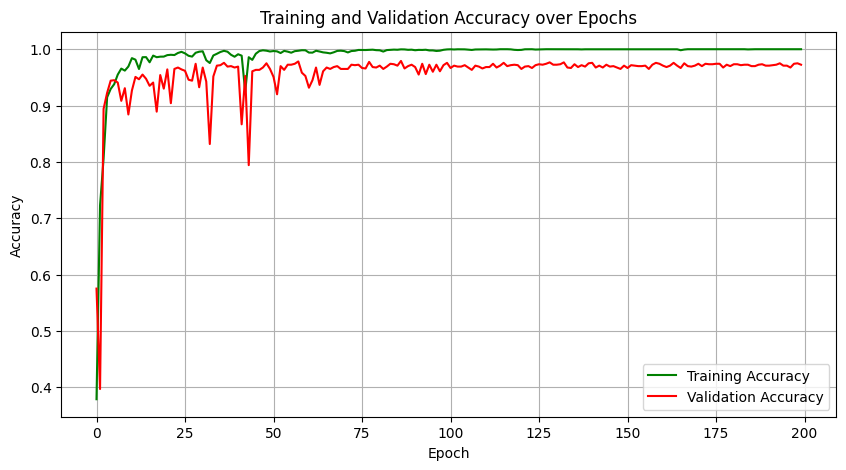

In [ ]:
import time
import matplotlib.pyplot as plt

total_start_time = time.time()
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
num_epochs = 200

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    epoch_train_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0

    for imgs, keypoints, _ in data_loader_train:
        imgs, keypoints = imgs.to(device), keypoints.to(device)
        
        outputs = model(imgs)
        loss = criterion(outputs, keypoints)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        
        with torch.no_grad():
            predicted_points = outputs.view(-1, 2)
            true_points = keypoints.view(-1, 2)
            distances = torch.norm(predicted_points - true_points, dim=1)
            correct_train_predictions += (distances < 0.05).sum().item()
            total_train_predictions += distances.size(0)
    
    epoch_train_loss /= len(data_loader_train)
    epoch_train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    model.eval()
    epoch_val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0

    with torch.no_grad():
        for imgs, keypoints, _ in val_data_loader:
            imgs, keypoints = imgs.to(device), keypoints.to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs, keypoints)
            epoch_val_loss += loss.item()
            
            predicted_points = outputs.view(-1, 2)
            true_points = keypoints.view(-1, 2)
            distances = torch.norm(predicted_points - true_points, dim=1)
            correct_val_predictions += (distances < 0.05).sum().item()
            total_val_predictions += distances.size(0)
    
    epoch_val_loss /= len(val_data_loader)
    epoch_val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}, "
          f"Time: {epoch_time:.2f} seconds")

total_time = time.time() - total_start_time
print(f"Total training and validation time: {total_time:.2f} seconds")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()


In [ ]:
torch.save(model.state_dict(), "best_model.pth")

In [13]:
model = HRNetKeypointRegressor(num_keypoints=num_keypoints).to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=torch.device('cpu')))

Unexpected keys (downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.num_batches_tracked, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.num_batches_tracked, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.num_batches_tracked, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.
/var/folders/n9/

<All keys matched successfully>

In [17]:
import os
import csv
import torch
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np

class TestDogHeartDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.imgs = list(sorted(os.listdir(root)))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        original_size = img.size

        if self.transform:
            img = self.transform(img)

        return img, self.imgs[idx], original_size

    def __len__(self):
        return len(self.imgs)

def get_test_transform(resized_image_size):
    return T.Compose([
        T.ToTensor(),
        T.Resize((resized_image_size, resized_image_size)),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


resized_image_size = 512

test_dataset = TestDogHeartDataset("Dog_Heart_VHS/Test/Images", transform=get_test_transform(resized_image_size))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


model.eval()

results = []

with torch.no_grad():
    for img, filename, original_size in test_loader:
        img = img.to(device)
        
        original_width, original_height = original_size[0].to(device), original_size[1].to(device)

        outputs = model(img)
        predicted_points = outputs.view(img.size(0), -1, 2)

        for i in range(predicted_points.size(0)):
            predicted_points[i, :, 0] *= original_width / resized_image_size
            predicted_points[i, :, 1] *= original_height / resized_image_size

        for i in range(predicted_points.size(0)):
            AB = torch.norm(predicted_points[i, 1] - predicted_points[i, 0])
            CD = torch.norm(predicted_points[i, 3] - predicted_points[i, 2])
            EF = torch.norm(predicted_points[i, 5] - predicted_points[i, 4])
            VHS = 6 * (AB + CD) / EF

            results.append({'Filename': filename[i], 'VHS': VHS.item()})

import pandas as pd
df = pd.DataFrame(results)
df.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv


# 3.Evaluate your model using the test images with the [software](https://github.com/YoushanZhang/Dog-Cardiomegaly_VHS)

# 4. Your results should be achieved 85%. VHS = 6(AB+CD)/EF

## (10 points, accuracy < 75% --> 0 points)

![Screenshot 2024-12-04 at 10.30.36 PM.png](<attachment:Screenshot 2024-12-04 at 10.30.36 PM.png>)
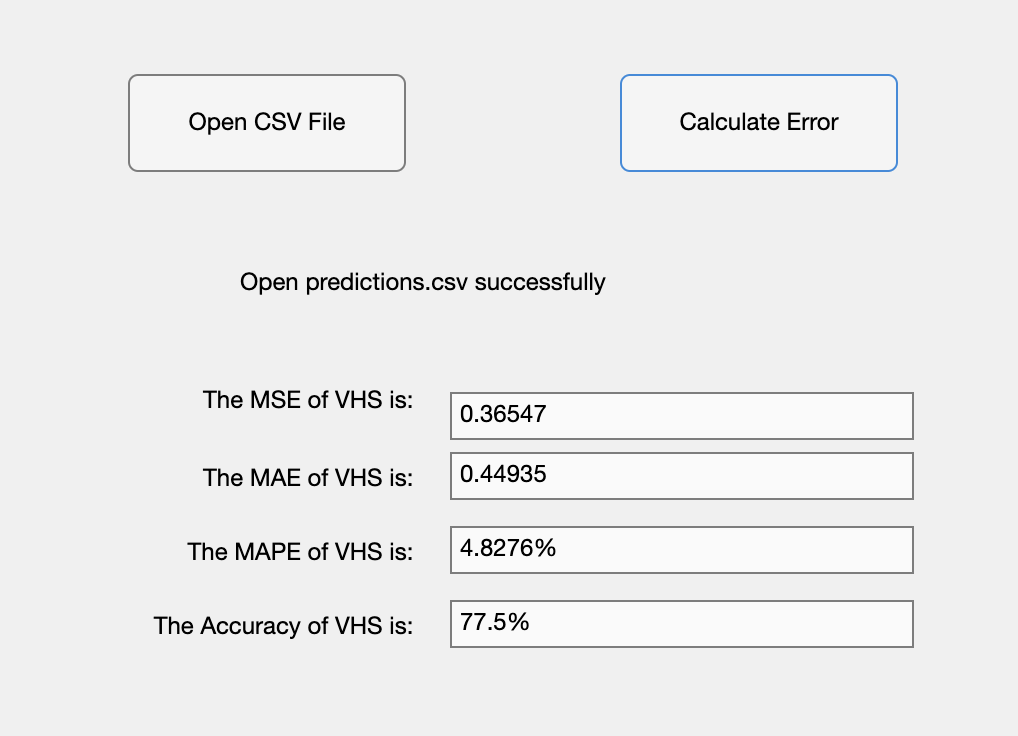

# 5. Show the comprison between predictions and ground truth
## You need to add the title with: image name, predicted VHS and Ground Truth VHS

# Please show the comprison results of images: 1420.png, 1479.png and 1530.png from Valid dataset

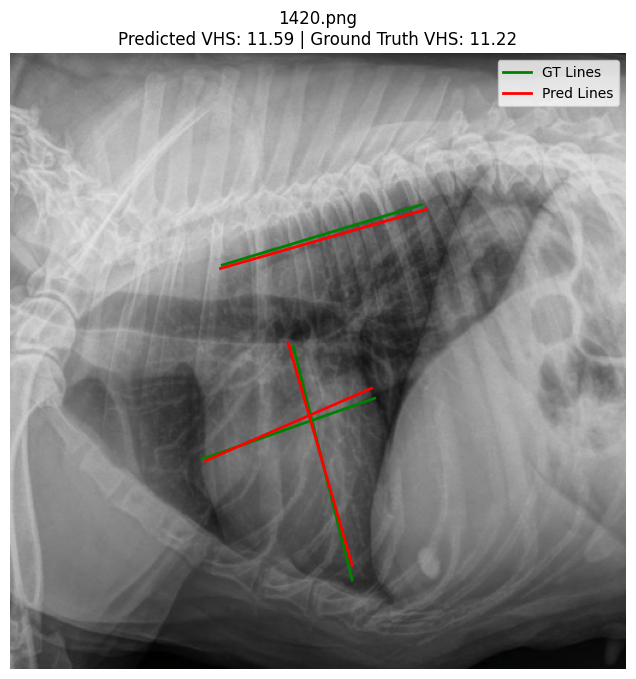

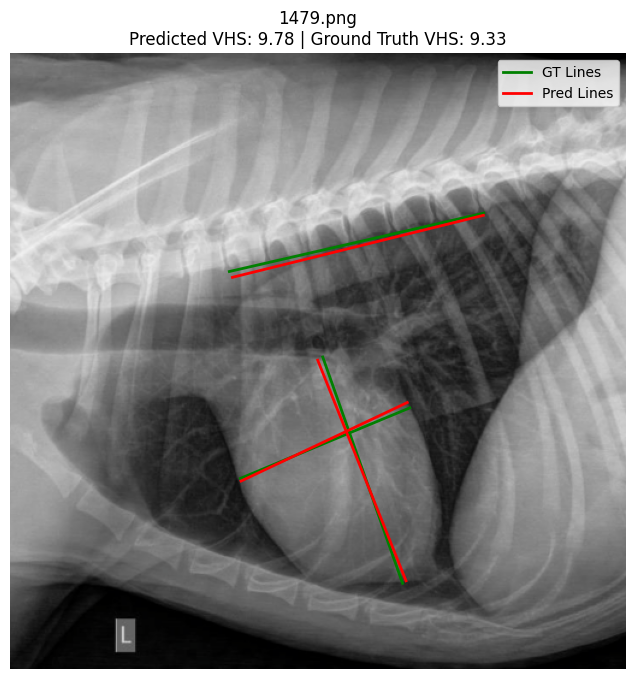

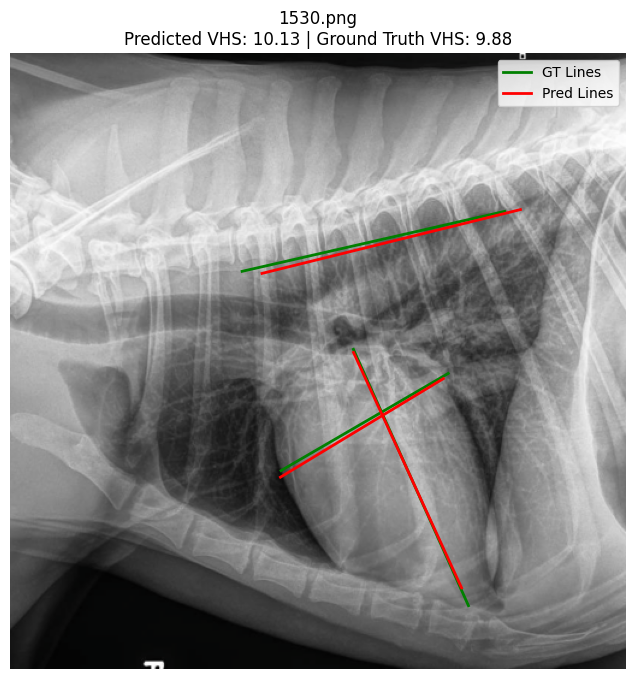

In [18]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt

class TargetImageLoader(Dataset):
    def __init__(self, root, transforms, target_images):
        self.root = root
        self.transforms = transforms
        self.target_images = target_images
        
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.points = list(sorted(os.listdir(os.path.join(root, "Labels"))))
        filtered_imgs = []
        filtered_points = []
        for img, label in zip(self.imgs, self.points):
            if os.path.basename(img) in target_images:
                filtered_imgs.append(img)
                filtered_points.append(label)
        
        self.imgs = filtered_imgs
        self.points = filtered_points

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        points_path = os.path.join(self.root, "Labels", self.points[idx])
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        if self.transforms is not None:
            img = self.transforms(img)
        h_new, w_new = img.shape[1], img.shape[2]
        mat = loadmat(points_path)
        six_points = mat['six_points'].astype(float)
        six_points = torch.as_tensor(six_points, dtype=torch.float32)
        six_points[:, 0] = w_new / w * six_points[:, 0]
        six_points[:, 1] = h_new / h * six_points[:, 1]
        six_points = torch.reshape(six_points, (-1,)) / h_new
        VHS = mat['VHS'].astype(float)
        VHS = torch.as_tensor(VHS, dtype=torch.float32)
        return img, six_points, VHS, os.path.basename(img_path)

def get_transform(resized_image_size):
    from torchvision.transforms import functional as F
    import torchvision.transforms as T
    transforms = []
    transforms.append(T.ToTensor())
    transforms.append(T.Resize(size=(resized_image_size, resized_image_size)))
    transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    return T.Compose(transforms)

def visualize_comparison(img, gt_keypoints, pred_keypoints, gt_vhs, pred_vhs):
    img = img.permute(1, 2, 0).cpu().numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = (img * 255).astype('uint8')

    gt_keypoints = gt_keypoints.cpu().view(-1, 2) * img.shape[0]
    pred_keypoints = pred_keypoints.cpu().view(-1, 2) * img.shape[0]

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    connections = [(0, 1), (2, 3), (4, 5)]

    for start, end in connections:
        plt.plot(
            [gt_keypoints[start, 0], gt_keypoints[end, 0]],
            [gt_keypoints[start, 1], gt_keypoints[end, 1]],
            c='green', linewidth=2, label='GT Lines' if "GT Lines" not in plt.gca().get_legend_handles_labels()[1] else None
        )

    for start, end in connections:
        plt.plot(
            [pred_keypoints[start, 0], pred_keypoints[end, 0]],
            [pred_keypoints[start, 1], pred_keypoints[end, 1]],
            c='red', linewidth=2, label='Pred Lines' if "Pred Lines" not in plt.gca().get_legend_handles_labels()[1] else None
        )

    plt.title(f"{filename}\nPredicted VHS: {pred_vhs:.2f} | Ground Truth VHS: {gt_vhs:.2f}")
    plt.legend()
    plt.axis('off')
    plt.show()

def calculate_vhs(points):
    AB = torch.norm(points[1] - points[0])
    CD = torch.norm(points[3] - points[2])
    EF = torch.norm(points[5] - points[4])
    return 6 * (AB + CD) / EF

val_img_dir = 'Dog_Heart_VHS/Valid'
target_images = ["1420.png", "1479.png", "1530.png"]
resized_image_size = 512

target_dataset = TargetImageLoader(val_img_dir, get_transform(resized_image_size), target_images)
target_loader = DataLoader(target_dataset, batch_size=1, shuffle=False)

model.eval()
for imgs, gt_keypoints, gt_vhs, filenames in target_loader:
    img = imgs[0]
    gt_keypoint = gt_keypoints[0]
    gt_vhs_val = gt_vhs[0].item()
    filename = filenames[0]

    with torch.no_grad():
        img_input = img.unsqueeze(0).to(device)
        pred_keypoints = model(img_input).view(-1, 2).cpu()
        pred_vhs = calculate_vhs(pred_keypoints)

    visualize_comparison(img, gt_keypoint, pred_keypoints, gt_vhs_val, pred_vhs)

# 6. Write a three-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


https://drive.google.com/drive/folders/1z8V0qgf8DLJxEoMzeSIJig0ynRrL8WuW?usp=sharing

https://www.researchgate.net/publication/386424985_HRNet-Based_Keypoint_Localization_for_Vertebral_Heart_Score_Prediction_in_Dogs

# 7. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, prediction CSV file and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points

# 8. Bonus points (10 points if your accuracy is higer than 87.3%)